In [17]:
import pandas as pd
from tqdm.notebook import tqdm

from requests import get, post
from time import sleep

import os,urllib,io
from urllib import parse, request

from matplotlib import pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment

import py3Dmol
from prody import *


def ViewModel(pdb):
    #view = py3Dmol.view(width=640,height=480,)
    struc=parsePDBStream(io.StringIO(pdb))
    view=showProtein(struc)
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()

    return struc,view

def PlotpLDDT(self):
    ax=sns.jointplot(y=self.getBetas(),x=self.getResnums(),c=self.getBetas(),kind='scatter',joint_kws={"color":None, 'cmap':'jet_r','vmin':0.5,'vmax':0.9},height=5,marker=".", 
                 s=50, marginal_kws=dict(bins=25, fill=False,color='green',kde=True),)
    ax.fig.colorbar(ax.ax_joint.collections[0], ax=[ax.ax_joint, ax.ax_marg_y, ax.ax_marg_x],shrink=0.7,use_gridspec=True, orientation='vertical',label='pLDDT')
    ax.ax_joint.set_xlabel('Residue Num')
    ax.ax_joint.set_ylabel('pLDDT')
    return ax

import warnings
warnings.filterwarnings(action='ignore')

def ModellProteinESMfold(seq,outfile='seq.pdb'):
    url='https://api.esmatlas.com/foldSequence/v1/pdb/'
    pdb=os.popen(f'curl -X POST --data {seq} {url}').read()
    if outfile !=None:
        f=open(outfile,'w')
        f.write(pdb)
        f.close()
    return pdb

def GetFooldSeek(pdbFile,dataBases=['afdb-swissprot','pdb100','afdb50'],aligmentMode='3diaa'):
    '''
    dataBases : list of ['afdb50','afdb-swissprot','afdb-proteome','mgnify_esm30','pdb100','gmgcl_id']
    aligmentMode: str ['3diaa','tmalign']
    '''
    table=pd.DataFrame()
    ticket = post('https://search.foldseek.com/api/ticket', {
                'q' :open(pdbFile,'r').read(),
                'database[]' :dataBases,
                'mode' : aligmentMode,
            }).json()
    if ticket['status'] != "COMPLETE":
        repeat = True
        print(ticket['status'])
    else:
        repeat=False
    
    while repeat:
        status =get('https://search.foldseek.com/api/ticket/' + ticket['id']).json()
        if status['status'] == "ERROR":
            # handle error
            sys.exit(0)

        # wait a short time between poll requests
        sleep(1)
        repeat = status['status'] != "COMPLETE"

    result = get('https://search.foldseek.com/api/result/' + ticket['id'] + '/0').json()

    for db in result['results']:
        if db['alignments']!=None:
            aligmentsTable=pd.json_normalize(db['alignments'])
            aligmentsTable['database']=[db['db'] for i in aligmentsTable.index]
            table=table.append(aligmentsTable,ignore_index=True)

    table.drop(columns=['query','tCa'],inplace=True)
    table['Tag']=[GenerateTag(table,index) for index in table.index]
    table.sort_values(by='eval',ascending=True,inplace=True,ignore_index=True)
    return table

def UniProt_DataFrame(idsList=[],queryType='ACC'):  
    url = 'https://legacy.uniprot.org/uploadlists/' 
    params = {
        'from':queryType,
        'to': 'ACC',
        'format': 'tab',
        'query': ';'.join(idsList),
        'columns': 'entry_name,id,protein_names,reviewed,annotation_score,existence,genes(PREFERRED),organism,organism-id,go(biological%20process),go(molecular%20function),go(cellular%20component),lineage(SUPERKINGDOM),lineage(KINGDOM),lineage(PHYLUM),database(PDB),database(pFam),database(interpro),rhea-id,ec,database(KEGG),database(BioCyc)'
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    result = urllib.request.urlopen(url, data)
    df_fasta = pd.read_csv(result, sep="\t")
    df_fasta.columns=['ENTRY_name','ENTRY_id','NAMES','STATUS','SCORE','EXISTENCE','GENE_name','ORGANISM_name','ORGANISM_id','GO_process','GO_function','GO_component','LINEAGE_superkingdom','LINEAGE_kingdom','LINEAGE_phylum','PDB_ids','PFAM_ids','InterPro','RHEA_id','EC_id','KEGG','BIOCYC','Tag']
    
    return df_fasta
    
def GenerateTag(table,index):
    tag=table.target[index]
    if 'afdb' in table.database[index]:
        tag=tag[tag.find('F-')+2:tag.find('-F')].strip()
    elif 'pdb' in table.database[index]:
        tag=tag.split('_')[0].strip()
    return tag


def Plot_GO(table,outfile=None,selection='all'):
    F = make_subplots(rows=1, cols=6,shared_xaxes=False,shared_yaxes=False,horizontal_spacing=0,subplot_titles=['GO_process','','','','','GO_function'])

    go_table=pd.DataFrame()
    for index in table.index:
        row=table.loc[index]
        if isinstance(row.GO_process,str):
            GO_terms=row.GO_process.split(';')
            for go in GO_terms:
                row.ORGANISM_name=row.ORGANISM_name.split("(")[0]
                row.GO_process=go.strip().split(',')[-1]
                go_table=go_table.append(row,ignore_index=True)
        else:pass
            #row.GO_process='Not available'
            #go_table=go_table.append(row,ignore_index=True)
    go_process=go_table.groupby(['GO_process','ORGANISM_name'])['tSeq'].count().reset_index(['GO_process','ORGANISM_name'])

    go_process.sort_values(by='ORGANISM_name',inplace=True,ignore_index=True)

    fig1 = px.bar(data_frame=go_process, x='tSeq',y='GO_process', color='ORGANISM_name',
                 orientation='h',color_discrete_sequence=px.colors.qualitative.Pastel)

 
    go_table=pd.DataFrame()
    for index in table.index:
        row=table.loc[index]
        if isinstance(row.GO_function,str):
            GO_terms=row.GO_function.split(';')
            for go in GO_terms:
                row.ORGANISM_name=row.ORGANISM_name.split("(")[0]
                row.GO_function=go.strip().split(',')[-1]
                go_table=go_table.append(row,ignore_index=True)
        else:pass
            #row.GO_function='Not available'
            #go_table=go_table.append(row,ignore_index=True)

    go_function=go_table.groupby(['GO_function','ORGANISM_name'],dropna=False)['tSeq'].count().reset_index(['GO_function','ORGANISM_name'])

    go_function.sort_values(by='ORGANISM_name',inplace=True,ignore_index=True)

    fig2 = px.bar(data_frame=go_function, x='tSeq',y='GO_function', color='ORGANISM_name',
                 orientation='h',color_discrete_sequence=px.colors.qualitative.Pastel)
    
    for d in fig1.data:
        d.showlegend=False
        F.add_trace(d,row=1,col=1)

    for d in fig2.data:
        d.showlegend=True
        F.add_trace(d,row=1,col=6)

    F.update_xaxes(title_text="Frequency",showgrid=True, row=1, col=1,)
    F.update_xaxes(title_text="Frequency", showgrid=True,row=1, col=6)

    F.update_layout(barmode='stack',height=800, width=1200, title_text=f"GO Associations (Organism names by UniProt)",plot_bgcolor='rgba(0, 0, 0, 0)',font=dict(size=11))
    if outfile:
        F.write_image(outfile,height=800, width=1200,validate=True,scale=2)
    else:
        pass
    return F

In [5]:
seq='MNKKKIILLFILTLVGILCVFLNGKEEPEIGVGQNKVSFSNKTNSFYYDQLDETEKRVCNDITALVEQGNGGKIDLTAPISTYRYLRIVRTLSFDPEYQNWAISLIFPVGENNKLIDRNTINDDCNIMKLYVLVNDSKKRKELKNFKLVLNDENIITNIDELEKICKNADFSTEYYQEKSKEIDACYDEIIKEMPKNMNEKEAVQYFLNWIKDNMEYDYSVYESSIEPYYDKLYENEVYADVSNKGCILDKRGICGGISIILSELCNRVGITAYPVFGTIKSDGTLIPHGWVAMRVDDSTYYIDPTYVCQTGEMDNLKMKNEMERIGDRQYQLEDSFEY'
pdbFromSeq=ModellProteinESMfold(seq,outfile='test.pdb')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  220k  100  219k  100   339  15848     23  0:00:14  0:00:14 --:--:-- 59904


In [14]:
Structure,view=ViewModel(pdbFromSeq)
view

@> 2760 atoms and 1 coordinate set(s) were parsed in 0.02s.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

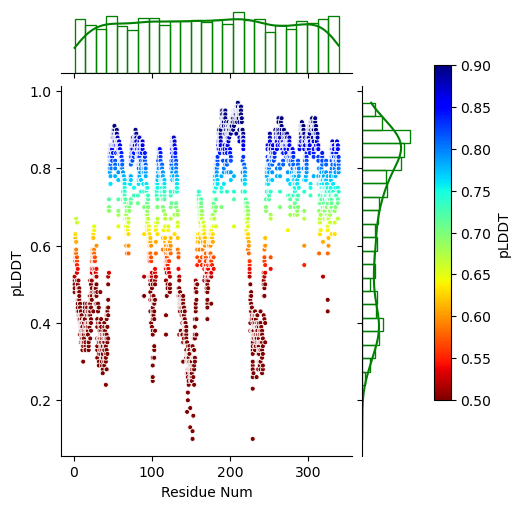

In [18]:
PlotpLDDT(Structure)

In [20]:
table=GetFooldSeek('test.pdb',dataBases=['afdb-swissprot','pdb100'])
print(table.shape)
table.head(3)

PENDING
(35, 20)


,target,seqId,alnLength,missmatches,gapsopened,qStartPos,qEndPos,dbStartPos,dbEndPos,eval,score,qLen,dbLen,qAln,dbAln,tSeq,taxId,taxName,database,Tag
0,4xz7_B,15.3,274,152,15,50,320,119,315,0.000001,346,339,382,QLDETEKRVCNDITALVEQGNGGKIDLTAPISTYRYLRIVRTLSFD...,ELDS------NKRQLLNAAG---LGTAE-NSLK-------------...,TNKIEVLNWEAFSKKLKDYSSDQRQFHVLKLGFENRLGTLSTREEL...,1307,Streptococcus suis,pdb100,4xz7
1,3isr_D,13.3,224,126,9,104,306,49,225,0.000114,264,339,285,SLIFPVGEN-NK-----LIDRNTINDDCNIMKLYV-----------...,IEIEEFSYNSGTSRFVRLKA---TENTTFSSYTATVDTQYKVIDQR...,LYFQSNAKFKIHSDITYQVSPTTFIFNVHALRTESQHILDESLIVT...,0,unclassified,pdb100,3isr
2,3isr_C,16.7,215,129,14,104,306,45,221,0.000160,258,339,281,SLIFPVGEN-NK-----LIDRNTINDDCNIMKLYV-----LVNDSK...,IEIEEFSYNSGTSRFVRLKA---TENTTFSSYTATVDTQYKVID--...,SNAKFKIHSDITYQVSPTTFIFNVHALRTESQHILDESLIVTPPIE...,0,unclassified,pdb100,3isr


In [21]:
referencesUniProt=pd.DataFrame()
AF=table[table.database.str.match('afdb')]
if len(AF.index)>0:
    AF_UniProt=UniProt_DataFrame(AF.Tag.to_list(),queryType='ACC')
    referencesUniProt=referencesUniProt.append(AF_UniProt,ignore_index=True)
else:pass

PDB=table[table.database.str.match('pdb')]
if len(PDB.index)>0:
    PDB_UniProt=UniProt_DataFrame(PDB.Tag.to_list(),queryType='PDB_ID')
    referencesUniProt=referencesUniProt.append(PDB_UniProt,ignore_index=True)
else:pass

print(referencesUniProt.shape)
referencesUniProt.head(3)

(60, 23)


,ENTRY_name,ENTRY_id,NAMES,STATUS,SCORE,EXISTENCE,GENE_name,ORGANISM_name,ORGANISM_id,GO_process,...,LINEAGE_kingdom,LINEAGE_phylum,PDB_ids,PFAM_ids,InterPro,RHEA_id,EC_id,KEGG,BIOCYC,Tag
0,Y384_ARCFU,O29863,UPF0252 protein AF_0384,reviewed,1 out of 5,Inferred from homology,NaN,Archaeoglobus fulgidus (strain ATCC 49558 / DS...,224325,NaN,...,NaN,Euryarchaeota,NaN,PF04473;,IPR038765;IPR007562;,NaN,NaN,afu:AF_0384;,NaN,O29863
1,Y607_MYCLE,Q49757,Uncharacterized protein ML0607,reviewed,1 out of 5,Predicted,NaN,Mycobacterium leprae (strain TN),272631,NaN,...,NaN,Actinobacteria,NaN,PF08379;PF01841;,IPR013589;IPR038765;IPR002931;,NaN,NaN,mle:ML0607;,NaN,Q49757
2,NGLY1_CHICK,Q5ZJM3,Peptide-N(4)-(N-acetyl-beta-glucosaminyl)aspar...,reviewed,3 out of 5,Evidence at transcript level,NGLY1,Gallus gallus (Chicken),9031,glycoprotein catabolic process [GO:0006516]; p...,...,Metazoa,Chordata,NaN,PF04721;PF09409;PF01841;,IPR008979;IPR038765;IPR038680;IPR006588;IPR036...,NaN,3.5.1.52,gga:420655;,NaN,Q5ZJM3


In [22]:
table=table.merge(referencesUniProt,on='Tag')
print(table.shape)
table.head(3)

(60, 42)


,target,seqId,alnLength,missmatches,gapsopened,qStartPos,qEndPos,dbStartPos,dbEndPos,eval,...,LINEAGE_superkingdom,LINEAGE_kingdom,LINEAGE_phylum,PDB_ids,PFAM_ids,InterPro,RHEA_id,EC_id,KEGG,BIOCYC
0,4xz7_B,15.3,274,152,15,50,320,119,315,0.000001,...,Bacteria,NaN,Firmicutes,4XZ7;,PF01841;,IPR038765;IPR002931;,NaN,NaN,NaN,NaN
1,3isr_D,13.3,224,126,9,104,306,49,225,0.000114,...,Bacteria,NaN,Bacteroidetes,3ISR;,PF01841;,IPR038765;IPR002931;,NaN,NaN,chu:CHU_2601;,NaN
2,3isr_C,16.7,215,129,14,104,306,45,221,0.000160,...,Bacteria,NaN,Bacteroidetes,3ISR;,PF01841;,IPR038765;IPR002931;,NaN,NaN,chu:CHU_2601;,NaN


In [24]:
table.to_csv('test_structuralSearch.tsv',sep='\t',index=False)